# Import 

In [3]:
!pip install transformers

In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel

from sklearn.model_selection import train_test_split
import logging
import re
import string
import nltk
from torch import cuda
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdallah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdallah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdallah\AppData\Roaming\nltk_data...


In [2]:
# stop_words = [ word for word in stop_words if word not in negation]

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

# Data explore

In [4]:
review_df = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")

In [5]:
review_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


Drop the user_id, Book_id, review_id, date_added, date_updated, read_at, and started_at we don't need them in our pipline

In [6]:
# Drop Dubplicate rows
review_df.drop_duplicates(subset=['review_text'], inplace=True)

In [7]:
review_df.drop(["user_id", "book_id", "review_id", "date_added", "date_updated", "read_at", "started_at"], axis =1, inplace=True)

In [8]:
review_df

,rating,review_text,n_votes,n_comments
0,5,This is a special book. It started slow for ab...,28,1
1,3,Recommended by Don Katz. Avail for free in Dec...,1,0
2,3,"A fun, fast paced science fiction thriller. I ...",22,0
3,0,Recommended reading to understand what is goin...,5,1
4,4,"I really enjoyed this book, and there is a lot...",9,1
...,...,...,...,...
899995,3,3.5 stars. \n Jenna is a popular YA author and...,0,0
899996,3,This was a quick read for me. I have read a lo...,1,1
899997,4,** spoiler alert ** \n 3.5 stars. \n This book...,1,0
899998,4,** spoiler alert ** \n Another fun read from M...,0,0


## Show the rating distribustion 

<Axes: title={'center': 'Rates Frequency'}, xlabel='rates', ylabel='Frequency'>

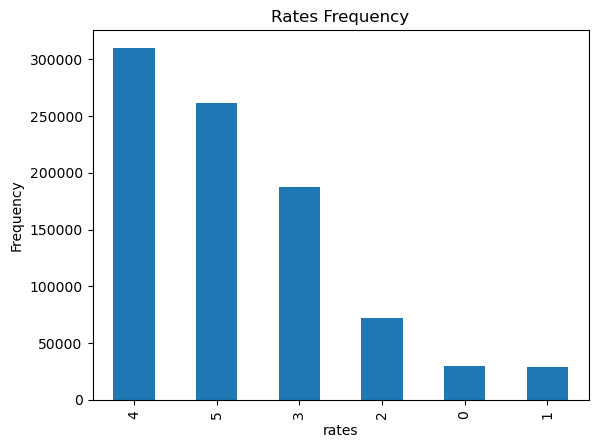

In [9]:
review_df.rating.value_counts().plot(kind="bar", xlabel="rates", ylabel="Frequency", title="Rates Frequency")

<strong> from this figure we can see that the rates 0 and 1 is less frequency rather than other rates  </strong>

## the correlation between votes and n_comments and rates|

<Axes: title={'center': 'n_comments dis'}, xlabel='n_comments', ylabel='Count'>

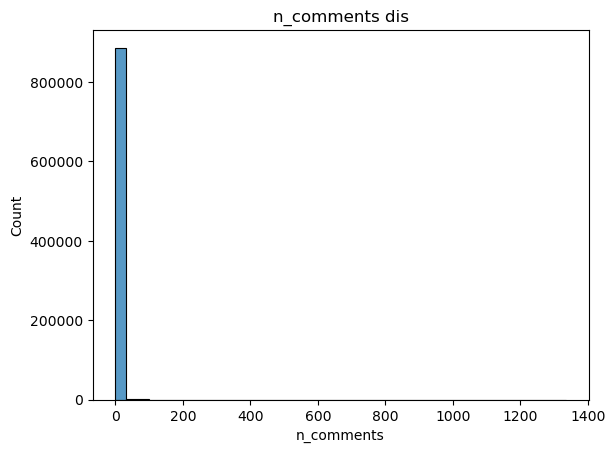

In [10]:
plt.title("n_comments dis")
sns.histplot(data = review_df, x= 'n_comments', bins=40)

In [11]:
review_df.n_comments.describe()

count    890254.000000
mean          1.025379
std           5.994267
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1335.000000
Name: n_comments, dtype: float64

<Axes: title={'center': 'n_votes dis'}, xlabel='n_votes', ylabel='Count'>

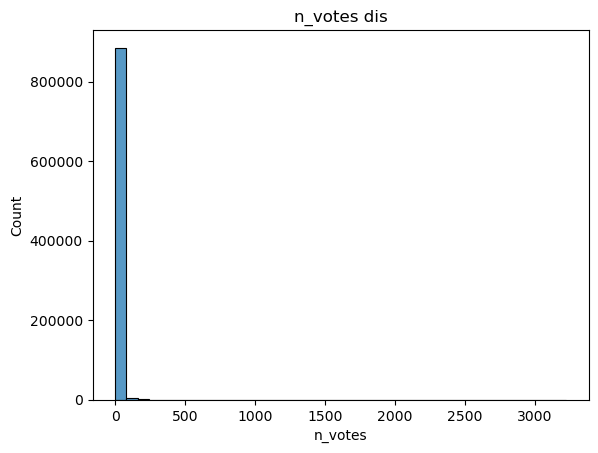

In [12]:
plt.title("n_votes dis")
sns.histplot(data = review_df, x= 'n_votes', bins=40)

In [13]:
review_df.n_votes.describe()

count    890254.000000
mean          3.319580
std          17.961004
min          -3.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        3222.000000
Name: n_votes, dtype: float64

**From this results n_votes and n_comments will not usefull for us**

In [14]:
review_df.drop(["n_comments", "n_votes"], axis =1, inplace=True)

## Take a Sample from the original data

In [15]:
# review_df = review_df.sample(int(len(review_df) * 0.3), random_state=42)


<Axes: title={'center': 'Rates Frequency'}, xlabel='rates', ylabel='Frequency'>

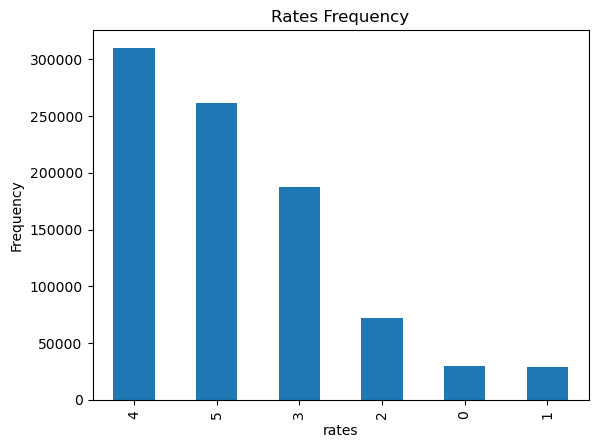

In [16]:
review_df.rating.value_counts().plot(kind="bar", xlabel="rates", ylabel="Frequency", title="Rates Frequency")

 <strong >fine tune code is from https://github.com/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb </strong>
 

# Text preprocessing

In [2]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained('../Deploy/tokinizer2',  truncation=True, do_lower_case=True)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


TypeError: stat: path should be string, bytes, os.PathLike or integer, not NoneType

: 

In [18]:
stop_words = set(stopwords.words('english'))
negation_words = ["didn", "weren", "doesn't"," hasn't", "couldn",
 "mustn't", "isn", "hadn't", "isn't", "wasn't", "mightn't",
 "couldn't", "needn't", "haven't", "shan't", "wouldn't",
 "not", "no", "never", "none", "nobody", "nowhere", "nothing","isn'", "'t",
 "shouldn't", "aren't", "didn't", "didn'", "don't", "hadn't", "won't", "wasn", "hadn"]
stop_words = [ word for word in stop_words if word not in negation_words]


In [19]:
class SentimentData(Dataset):
    def __init__(self, dataframe_input, tokenizer, max_len, stop_wrods, negation_words, data_type="train"):
        self.tokenizer = tokenizer
        self.data_type = data_type
        self.data = dataframe_input
        self.text = dataframe_input.review_text.values
        self.stop_wrods = stop_wrods
        self.negation_words = negation_words

        if data_type != "train":
            self.review_id = self.data.review_id.values

        if data_type == "train":
            self.targets = self.data.rating
        self.max_len = max_len

    def __len__(self):
        return len(self.text)
    
    def preprocess_text(self, text):
        # Remove unnecessary white spaces
        text = " ".join(text.split())

        # Remove HTML tags
        text = re.sub('<[^<]+?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
         
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        splited_text = text.split()
        cleaned_text = []
        for word in splited_text:
            if word not in self.stop_wrods:
                cleaned_text.append(word)
            elif word in self.negation_words:
                cleaned_text.append("not")
        text  = " ".join(cleaned_text)


#         Tokenize the text
#         tokens = tokenizer.tokenize(text)

#         Remove stopwords
#         c
#         tokens = [word for word in tokens if not word in stop_words]

#         Lemmatize the tokens
#         lemmatizer = WordNetLemmatizer()
#         tokens = [lemmatizer.lemmatize(word) for word in tokens]

#         Join the tokens back into a string
#         preprocessed_text = ' '.join(tokens)

        return text

    def __getitem__(self, index):
        text = str(self.text[index])
        text = self.preprocess_text(text)
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        if self.data_type == "train":
             return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets':  torch.tensor(self.targets[index], dtype=torch.float)

        }

        else:
             return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'review_id' : self.review_id[index]
                }

## Train Test Split

In [20]:
X_train, X_test, _, _ = train_test_split(review_df, review_df, test_size=0.1, random_state=42)
X_valid, X_test, _, _ = train_test_split(X_test, X_test, test_size=0.5, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_valid.reset_index(inplace=True, drop=True)

print("FULL Dataset: {}".format(review_df.shape))
print("TRAIN Dataset: {}".format(X_train.shape))
print("Valid Dataset: {}".format(X_valid.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_set = SentimentData(X_train, tokenizer, MAX_LEN, stop_words, negation_words )
validation_set = SentimentData(X_valid, tokenizer, MAX_LEN, stop_words, negation_words)
testing_set = SentimentData(X_test, tokenizer, MAX_LEN, stop_words, negation_words)


FULL Dataset: (890254, 2)
TRAIN Dataset: (801228, 2)
Valid Dataset: (44513, 2)
TEST Dataset: (44513, 2)


In [21]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2,
                'pin_memory':True
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2,
               'pin_memory':True
                }

training_loader = DataLoader(training_set, **train_params)
vlidation_loader = DataLoader(validation_set, **train_params)

testing_loader = DataLoader(testing_set, **test_params)

# Modeling

In [22]:
class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [23]:
model = DistilBertClass()
model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [24]:
counts = X_train.rating.value_counts()
class0 = counts[0]
class1 = counts[1]
class2 = counts[2]
class3 = counts[3]
class4 = counts[4]
class5 = counts[5]

total = class0 + class1 + class1 + class2 + class3 + class4 + class5

weight_for_0 = (1 / class0) * (total / 2.0)
weight_for_1 = (1 / class1) * (total / 2.0)
weight_for_2 = (1 / class2) * (total / 2.0)
weight_for_3 = (1 / class3) * (total / 2.0)
weight_for_4 = (1 / class4) * (total / 2.0)
weight_for_5 = (1 / class5) * (total / 2.0)

class_w = [weight_for_0, weight_for_1, weight_for_2, weight_for_3, weight_for_4, weight_for_5]

In [26]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss(weight =  torch.FloatTensor(class_w).to(device))
# optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)



In [27]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [28]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Training Loss per 5000 steps: 1.8098084926605225
Training Accuracy per 5000 steps: 12.5


5002it [08:56,  9.37it/s]

Training Loss per 5000 steps: 1.4266310643968618
Training Accuracy per 5000 steps: 42.33653269346131


10002it [17:49,  9.47it/s]

Training Loss per 5000 steps: 1.3628817019599901
Training Accuracy per 5000 steps: 45.2029797020298


15002it [26:41,  9.44it/s]

Training Loss per 5000 steps: 1.328347058451086
Training Accuracy per 5000 steps: 46.72021865208986


20002it [35:35,  9.40it/s]

Training Loss per 5000 steps: 1.306714876166797
Training Accuracy per 5000 steps: 47.48075096245188


25002it [44:30,  9.46it/s]

Training Loss per 5000 steps: 1.2889939692491417
Training Accuracy per 5000 steps: 48.13457461701532


30002it [53:23,  9.47it/s]

Training Loss per 5000 steps: 1.2758406850491868
Training Accuracy per 5000 steps: 48.677544081863935


35002it [1:02:15,  9.49it/s]

Training Loss per 5000 steps: 1.263442942355109
Training Accuracy per 5000 steps: 49.185380417702355


40002it [1:11:07,  9.47it/s]

Training Loss per 5000 steps: 1.2548766100541648
Training Accuracy per 5000 steps: 49.58219794505138


45002it [1:19:59,  9.39it/s]

Training Loss per 5000 steps: 1.2470841638639405
Training Accuracy per 5000 steps: 49.909724228350484


50002it [1:28:53,  9.42it/s]

Training Loss per 5000 steps: 1.2401651547084138
Training Accuracy per 5000 steps: 50.2402451950961


55002it [1:37:47,  9.30it/s]

Training Loss per 5000 steps: 1.2339797284273197
Training Accuracy per 5000 steps: 50.45521899601825


60002it [1:46:39,  9.45it/s]

Training Loss per 5000 steps: 1.2278068479436692
Training Accuracy per 5000 steps: 50.653530774487095


61470it [1:49:15,  9.49it/s]

In [ ]:
# tokenizer.save_pretrained("./tokinizer3")

# print('All files saved')

# Submmetion

In [ ]:
new_tokenizer = RobertaTokenizer.from_pretrained('/kaggle/working/tokinizer2')
model.load_state_dict(torch.load('/kaggle/working/model_RoBERTa2.pt'))
model.to("cpu")

In [52]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

In [ ]:
quantized_model

In [26]:
final_test = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv")
final_test.drop(["user_id", "book_id", "date_added", "date_updated", "read_at", "started_at", "n_comments", "n_votes"], axis =1, inplace=True)

In [22]:
final_test.drop(final_test[1:].index.values, inplace =True)

In [23]:
final_test.loc[0,"review_text"]= "I don't hate" 

In [27]:
final_test

,review_id,review_text
0,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...
1,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink..."
2,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...
3,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...
4,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,Can't wait for Travis' POV \n Travis Before Ab...
478029,0b7f352e58caf0fd1f961e98ef04e89c,Had this on my to-read shelf forever. Will upd...
478030,9b19eff33ddb14e9e68fca2e90379e46,The last book left me wanting for more. I need...
478031,8be463fed78f0da63e964706f710332b,Things are heating up in the second novel of I...


In [37]:
final_test_set = SentimentData(final_test, new_tokenizer, MAX_LEN, stop_words, negation_words, "test")
test_params = {'batch_size': 32,
                'shuffle': False,
                'num_workers': 2,
               'pin_memory':True
                }

final_test_set = DataLoader(final_test_set, **test_params)

In [38]:
import torch.nn.functional as F

In [53]:
def final_submmit(model, testing_loader):
    device = 'cpu'
    prediction_ids = []
    preds = []
    model.eval()
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            review_id = data["review_id"]
            outputs = model(ids, mask, token_type_ids)
            softmax_output = F.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(softmax_output, dim=1)
            prediction_ids.extend(review_id)
            preds.extend(predicted_classes.cpu().numpy())

        df = pd.DataFrame({'review_id': prediction_ids , "rating": preds })
        return df


In [ ]:
final_submmit = final_submmit(quantized_model, final_test_set)

In [ ]:
final_submmit

In [ ]:
final_submmit.to_csv("submmesion2.csv", index=False)

In [ ]:
d = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv")

In [ ]:
0.88 0.4 0.2 0.2 0.2 0.2

In [ ]:
stop_words = set(stopwords.words('english'))
negation_words = ["didn", "weren", "doesn't"," hasn't", "couldn",
 "mustn't", "isn", "hadn't", "isn't", "wasn't", "mightn't",
 "couldn't", "needn't", "haven't", "shan't", "wouldn't",
 "not", "no", "never", "none", "nobody", "nowhere", "nothing","isn'", "'t",
 "shouldn't", "aren't", "didn't", "didn'", "don't", "hadn't", "won't", "wasn", "hadn"]
stop_words = [ word for word in stop_words if word not in negation_words]


In [ ]:
class Senti_Toknizer():
    def __init__(self, tokenizer, stop_wrods, negation_words, max_len=256):
        self.tokenizer = tokenizer
        self.stop_wrods = stop_wrods
        self.negation_words = negation_words
        self.max_len = max_len
        
    def preprocess_text(self, text):
        # Remove unnecessary white spaces
        text = " ".join(text.split())

        # Remove HTML tags
        text = re.sub('<[^<]+?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
         
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        splited_text = text.split()
        cleaned_text = []
        for word in splited_text:
            if word not in self.stop_wrods:
                cleaned_text.append(word)
            elif word in self.negation_words:
                cleaned_text.append("not")
        text  = " ".join(cleaned_text)
        return text

    def toknize(self, text):
        text = self.preprocess_text(text)
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)}


In [ ]:
g = Senti_Toknizer( new_tokenizer, stop_words, negation_words,)

In [ ]:
y = g.toknize("this book is not so good but the matrial of the paper is good over all this book is well made")

In [ ]:
model.eval()
with torch.no_grad():
    
    ids = y['ids'].to(device, dtype = torch.long).unsqueeze(0)
    mask = y['mask'].to(device, dtype = torch.long).unsqueeze(0)
    token_type_ids = y['token_type_ids'].to(device, dtype=torch.long).unsqueeze(0)  
    outputs = model(ids, mask, token_type_ids)
    
    softmax_output = F.softmax(outputs, dim=1)

    N_propa = torch.sum(softmax_output[0,0:3]) 
    P_propa = torch.sum(softmax_output[0,3:])
    
    print (f"Positive probability {P_propa}, Negative Propability {N_propa}")

In [ ]:
softmax_output

In [ ]:
softmax_output[0,0:3]

In [ ]:
softmax_output[0,3:]

In [ ]:
softmax_output

In [64]:
torch.save(quantized_model, 'qun_model_RoBERTa3w.pth')


In [65]:
c = torch.load('/kaggle/working/qun_model_RoBERTa3w.pth')

In [66]:
c

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (key): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (value): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
              (dropout): Dropout(p=0.1, inplace=False)
      